# Hackaton IT-volontaire 25.07.2022 - 02.08.2022
## Задача 2. Бухгалтерская отчетность
### Ментор — Михаил Белоус

Из Росстата получены данные бухгалтерской отчетности всех действующих на май 2022 года фондов в России:

- Благотворительные фонды (ОКОПФ 070401)
- Общественные фонды (ОКОПФ 070403)
- Экологические фонды (ОКОПФ 070404)

Данные представлены за 2017-2021 годы. Считаем, что если в данных нет сведений по отчетности за какой-то год, это означает, что организация не предоставила отчетность за этот год.

- Очистить и описать данные
- Для тех организаций, которые подали отчетность, узнать, есть ли связь между материальным благополучием фонда и количеством штатных работников
- Определить факторы, влияющие на закредитованность, финансовое благополучие организации
- Любые дополнительные выводы и проверки

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [216]:
df = pd.read_excel('moscow.xlsx', sheet_name=1, header=3)
df.head()

,№,Наименование,Регистрационный номер,Дата регистрации,Статус,Код налогоплательщика,Регион регистрации,Код ОКАТО,Наименование ОКАТО,Код ОКТМО,...,"2017, Всего использовано средств, RUB","2018, Всего использовано средств, RUB","2019, Всего использовано средств, RUB","2020, Всего использовано средств, RUB","2021, Всего использовано средств, RUB","2017, Остаток средств на конец отчетного года, RUB","2018, Остаток средств на конец отчетного года, RUB","2019, Остаток средств на конец отчетного года, RUB","2020, Остаток средств на конец отчетного года, RUB","2021, Остаток средств на конец отчетного года, RUB"
0,1,"101 КИЛОМЕТР. ПОДВИЖНИКИ МАЛОЯРОСЛАВЦА, БФ",1.167700e+12,2016-05-24 00:00:00,Действующая,7.728340e+09,Москва,45293598000,"Москва, Юго-Западный, Ясенево",4.591000e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"12, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД",1.157700e+12,2015-01-23 00:00:00,Действующая,7.714327e+09,Москва,45277598000,"Москва, Северный, Хорошевский",4.534800e+10,...,26152000.0,37596000.0,55565000.0,100240000.0,66550000.0,264000.0,182000.0,113857000.0,311245000.0,424930000.0
2,3,"1ПОМОГАЕТ, БФ",1.167700e+12,2016-04-28 00:00:00,Действующая,9.718006e+09,Москва,45263552000,"Москва, Восточный, Богородское",4.530100e+10,...,1458000.0,2559000.0,4027000.0,8474000.0,7814000.0,132000.0,1208000.0,1105000.0,898000.0,2313000.0
3,4,"3Д, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД",1.197700e+12,2019-08-13 00:00:00,Действующая,9.703000e+09,Москва,45286575000,"Москва, Центральный, Пресненский",4.538000e+10,...,NaN,NaN,213000.0,96000.0,35000.0,NaN,NaN,39000.0,43000.0,8000.0
4,5,"459 ОРСПН, ФОНД",1.217700e+12,2021-10-06 00:00:00,Действующая,9.721146e+09,Москва,45290578000,"Москва, Юго-Восточный, Нижегородский",4.539200e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Удаляем ненужные признаки

In [217]:
df.drop(['№', 'Регион регистрации', 'Код ОКАТО', 'Код ОКТМО', 'Код ОКОПФ', 'Код налогоплательщика'], axis=1, inplace=True)

In [218]:
df.shape

(3647, 156)

### Удалим полные дубликаты

In [219]:
dupl_columns = list(df.columns)
mask = df.duplicated(subset=dupl_columns)
df_duplicates = df[mask]
print(f'Число найденных дубликатов: {df_duplicates.shape[0]}')

Число найденных дубликатов: 0


In [220]:
display(df.isnull().mean() * 100)

Наименование                                           0.000000
Регистрационный номер                                  0.054840
Дата регистрации                                       0.000000
Статус                                                 0.000000
Наименование ОКАТО                                     0.000000
                                                        ...    
2017, Остаток средств на конец отчетного года, RUB    80.285166
2018, Остаток средств на конец отчетного года, RUB    75.431862
2019, Остаток средств на конец отчетного года, RUB    71.894708
2020, Остаток средств на конец отчетного года, RUB    70.578558
2021, Остаток средств на конец отчетного года, RUB    71.044694
Length: 156, dtype: float64

In [221]:
df.head(3)

,Наименование,Регистрационный номер,Дата регистрации,Статус,Наименование ОКАТО,Организационно-правовая форма,"2017, Среднесписочная численность работников","2018, Среднесписочная численность работников","2019, Среднесписочная численность работников","2020, Среднесписочная численность работников",...,"2017, Всего использовано средств, RUB","2018, Всего использовано средств, RUB","2019, Всего использовано средств, RUB","2020, Всего использовано средств, RUB","2021, Всего использовано средств, RUB","2017, Остаток средств на конец отчетного года, RUB","2018, Остаток средств на конец отчетного года, RUB","2019, Остаток средств на конец отчетного года, RUB","2020, Остаток средств на конец отчетного года, RUB","2021, Остаток средств на конец отчетного года, RUB"
0,"101 КИЛОМЕТР. ПОДВИЖНИКИ МАЛОЯРОСЛАВЦА, БФ",1.167700e+12,2016-05-24 00:00:00,Действующая,"Москва, Юго-Западный, Ясенево",Благотворительные фонды,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"12, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД",1.157700e+12,2015-01-23 00:00:00,Действующая,"Москва, Северный, Хорошевский",Благотворительные фонды,NaN,NaN,NaN,NaN,...,26152000.0,37596000.0,55565000.0,100240000.0,66550000.0,264000.0,182000.0,113857000.0,311245000.0,424930000.0
2,"1ПОМОГАЕТ, БФ",1.167700e+12,2016-04-28 00:00:00,Действующая,"Москва, Восточный, Богородское",Благотворительные фонды,0 - 5,NaN,NaN,NaN,...,1458000.0,2559000.0,4027000.0,8474000.0,7814000.0,132000.0,1208000.0,1105000.0,898000.0,2313000.0


### Выделим из признака "Наименование ОКАТО" отдельно район Москвы и его расположение

In [222]:
def get_parse_direction(location):
    location = location.split(', ')[1:]
    if len(location):
        return location[0]
    else:
        return ''

def get_parse_location_name(location):
    location = location.split(', ')[1:]
    if len(location) == 2:
        return location[1]
    else:
        return ''
    

In [223]:
df['direction'] = df['Наименование ОКАТО'].apply(get_parse_direction)
df['location_name'] = df['Наименование ОКАТО'].apply(get_parse_location_name)

df.drop(['Наименование ОКАТО'], axis=1, inplace=True)

In [224]:
df[['direction', 'location_name']].head()

,direction,location_name
0,Юго-Западный,Ясенево
1,Северный,Хорошевский
2,Восточный,Богородское
3,Центральный,Пресненский
4,Юго-Восточный,Нижегородский


### Заполним пропуски пока нулями, в интересующих нас столбцах

In [225]:
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    
    # всего поступило средств EC, ED, EE, EF, EG
    '2017, Всего поступило средств, RUB': 0,
    '2018, Всего поступило средств, RUB': 0,
    '2019, Всего поступило средств, RUB': 0,
    '2020, Всего поступило средств, RUB': 0,
    '2021, Всего поступило средств, RUB': 0,
    # всего использовано средств EW, EX, EY, EZ, FA
    '2017, Всего использовано средств, RUB': 0,
    '2018, Всего использовано средств, RUB': 0,
    '2019, Всего использовано средств, RUB': 0,
    '2020, Всего использовано средств, RUB': 0,
    '2021, Всего использовано средств, RUB': 0,
    
    # расходы на содержание аппарата управления EM, EN, EO, EP, EQ
    '2017, Расходы на содержание аппарата управления, RUB': 0,
    '2018, Расходы на содержание аппарата управления, RUB': 0,
    '2019, Расходы на содержание аппарата управления, RUB': 0,
    '2020, Расходы на содержание аппарата управления, RUB': 0,
    '2021, Расходы на содержание аппарата управления, RUB': 0,   
    
    '2017, Среднесписочная численность работников': 0,
    '2018, Среднесписочная численность работников': 0
    
}
#заполняем пропуски в соответствии с заявленным словарем
df = df.fillna(values)
#выводим результирующую долю пропусков
df.isnull().mean()

Наименование                                          0.000000
Регистрационный номер                                 0.000548
Дата регистрации                                      0.000000
Статус                                                0.000000
Организационно-правовая форма                         0.000000
                                                        ...   
2019, Остаток средств на конец отчетного года, RUB    0.718947
2020, Остаток средств на конец отчетного года, RUB    0.705786
2021, Остаток средств на конец отчетного года, RUB    0.710447
direction                                             0.000000
location_name                                         0.000000
Length: 157, dtype: float64

### Преобразуем признак с численностью сотрудников в удобный вид

In [226]:
def get_employees(persons):
    if persons == 0 or persons == '0':
        return 0
    if persons == '0 - 5':
        return 5
    elif persons == '6 - 10':
        return 10
    elif persons == '16 - 50':
        return 50
    elif persons == '51 - 100':
        return 100
    elif persons == '101 - 150':
        return 150
    elif persons == '151 - 200':
        return 200
    elif persons == '201 - 250':
        return 250
    elif persons == '201 - 250':
        return 250
    elif persons == '251 - 500':
        return 500
    elif persons == '501 - 1000':
        return 1000
    

In [227]:
df['2017_employees'] = df['2017, Среднесписочная численность работников'].apply(get_employees)
df['2018_employees'] = df['2018, Среднесписочная численность работников'].apply(get_employees)
df['legal_form'] = df['Организационно-правовая форма']
df['name'] = df['Наименование']
df['2017_management_costs'] = df['2017, Расходы на содержание аппарата управления, RUB']
df['2018_management_costs'] = df['2018, Расходы на содержание аппарата управления, RUB']
df['2019_management_costs'] = df['2019, Расходы на содержание аппарата управления, RUB']
df['2020_management_costs'] = df['2020, Расходы на содержание аппарата управления, RUB']
df['2021_management_costs'] = df['2021, Расходы на содержание аппарата управления, RUB']

df.drop([
    'Наименование',
    'Организационно-правовая форма',
    '2017, Остаток средств на конец отчетного года, RUB',
    '2018, Остаток средств на конец отчетного года, RUB',
    '2019, Остаток средств на конец отчетного года, RUB',
    '2020, Остаток средств на конец отчетного года, RUB',
    '2021, Остаток средств на конец отчетного года, RUB',
    '2017, Расходы на содержание аппарата управления, RUB',
    '2018, Расходы на содержание аппарата управления, RUB',
    '2019, Расходы на содержание аппарата управления, RUB',
    '2020, Расходы на содержание аппарата управления, RUB',
    '2021, Расходы на содержание аппарата управления, RUB',
    '2017, Среднесписочная численность работников',
    '2018, Среднесписочная численность работников',
    '2019, Среднесписочная численность работников',
    '2020, Среднесписочная численность работников',
    '2021, Среднесписочная численность работников'], axis=1, inplace=True)

### Вычислим благосостояние как разницу между всеми поступившими всеми использованными средствами
вычисляем в млн руб

In [228]:
df['2017_well_being'] = (df['2017, Всего поступило средств, RUB'] - df['2017, Всего использовано средств, RUB'])/1e6
    
df['2018_well_being'] = (df['2018, Всего поступило средств, RUB'] - df['2018, Всего использовано средств, RUB'])/1e6

df['2019_well_being'] = (df['2019, Всего поступило средств, RUB'] - df['2019, Всего использовано средств, RUB'])/1e6

df['2020_well_being'] = (df['2020, Всего поступило средств, RUB'] - df['2020, Всего использовано средств, RUB'])/1e6

df['2021_well_being'] = (df['2021, Всего поступило средств, RUB'] - df['2021, Всего использовано средств, RUB'])/1e6

In [229]:
df.head()

,Регистрационный номер,Дата регистрации,Статус,"2017, Доходы, RUB","2018, Доходы, RUB","2019, Доходы, RUB","2020, Доходы, RUB","2021, Доходы, RUB","2017, Расходы, RUB","2018, Расходы, RUB",...,2017_management_costs,2018_management_costs,2019_management_costs,2020_management_costs,2021_management_costs,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being
0,1.167700e+12,2016-05-24 00:00:00,Действующая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
1,1.157700e+12,2015-01-23 00:00:00,Действующая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,644000.0,396000.0,1915000.0,3765000.0,8969000.0,-1.555,-0.082,113.675,197.388,113.685
2,1.167700e+12,2016-04-28 00:00:00,Действующая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213000.0,243000.0,877000.0,1549000.0,1438000.0,0.075,1.076,-0.104,-0.207,1.415
3,1.197700e+12,2019-08-13 00:00:00,Действующая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,8000.0,96000.0,0.0,0.000,0.000,0.039,0.004,-0.035
4,1.217700e+12,2021-10-06 00:00:00,Действующая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000


In [230]:
df['Статус'].value_counts()

Действующая       3644
Реорганизуется       3
Name: Статус, dtype: int64

Статусом можем принебречь, так как осноная часть фондов действующая.

### Выделяем столбцы, содержащие наши метрики

In [231]:
cols = [
    'name',
    'legal_form',
    '2017_employees',
    '2018_employees',
    '2017_well_being',
    '2018_well_being',
    '2019_well_being',
    '2020_well_being',
    '2021_well_being',
    '2017_management_costs',
    '2018_management_costs',
    '2019_management_costs',
    '2020_management_costs',
    '2021_management_costs'
    ]
df_set = df[cols]

In [232]:
df_set.head()

,name,legal_form,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being,2017_management_costs,2018_management_costs,2019_management_costs,2020_management_costs,2021_management_costs
0,"101 КИЛОМЕТР. ПОДВИЖНИКИ МАЛОЯРОСЛАВЦА, БФ",Благотворительные фонды,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
1,"12, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД",Благотворительные фонды,0.0,0.0,-1.555,-0.082,113.675,197.388,113.685,644000.0,396000.0,1915000.0,3765000.0,8969000.0
2,"1ПОМОГАЕТ, БФ",Благотворительные фонды,5.0,0.0,0.075,1.076,-0.104,-0.207,1.415,213000.0,243000.0,877000.0,1549000.0,1438000.0
3,"3Д, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД",Благотворительные фонды,0.0,0.0,0.000,0.000,0.039,0.004,-0.035,0.0,0.0,8000.0,96000.0,0.0
4,"459 ОРСПН, ФОНД",Благотворительные фонды,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0


In [233]:
df_set.shape

(3647, 14)

### Отфильтруем только фонды, подавшие сведения о сотрудниках хотя бы в одном году (2017 или 2018) 

In [234]:
values = {
    '2017_employees': 0,
    '2018_employees': 0
}
df_set = df_set.fillna(values)

In [235]:
mask = (df_set['2017_employees'] > 0) | (df_set['2018_employees'] > 0)
df_set = df_set[mask]

In [236]:
print('Осталось: ', df_set.shape[0], 'фондов.')

Осталось:  443 фондов.


In [237]:
df_set['legal_form'].value_counts()

Благотворительные фонды    350
Общественные фонды          86
Фонды                        6
Экологические фонды          1
Name: legal_form, dtype: int64

### Оставим только благотворительные и общественные фонды

In [238]:
mask = (df_set['legal_form'] == 'Благотворительные фонды') | (df_set['legal_form'] == 'Общественные фонды')
df_set = df_set[mask]

In [239]:
print('Осталось: ', df_set.shape[0], 'фондов.')

Осталось:  436 фондов.


### Основные статистики по нашим метрикам

In [240]:
df_set.describe()

,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being,2017_management_costs,2018_management_costs,2019_management_costs,2020_management_costs,2021_management_costs
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,4.360000e+02,4.360000e+02,4.360000e+02,4.360000e+02,4.360000e+02
mean,11.972477,6.651376,-2.178076,4.800188,5.174635,10.736119,4.780943,5.310722e+06,5.095420e+06,4.887505e+06,4.634459e+06,5.788624e+06
std,34.920391,34.096247,50.557077,77.899107,81.997834,97.816824,123.578160,2.839117e+07,1.584402e+07,1.458627e+07,1.337986e+07,1.813011e+07
min,0.000000,0.000000,-494.920000,-415.215000,-775.439000,-648.250000,-1399.455000,0.000000e+00,-1.110000e+06,-5.241000e+06,-9.301000e+06,-9.677000e+06
25%,5.000000,0.000000,-0.230750,-0.306250,-0.395000,-0.126500,-0.394000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.705000e+05,6.060000e+05,6.195000e+05,5.810000e+05,6.295000e+05
75%,5.000000,0.000000,0.268250,0.490750,0.805500,2.112750,0.781000,2.581000e+06,3.698250e+06,3.387000e+06,3.307000e+06,3.686250e+06
max,500.000000,500.000000,317.504000,887.283000,864.543000,1309.543000,1123.365000,4.935350e+08,2.017830e+08,1.477710e+08,1.465950e+08,1.835360e+08


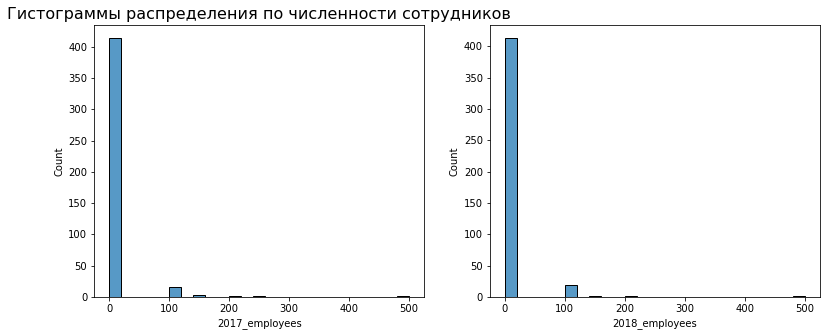

In [241]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.histplot(
    data=df_set,
    x='2017_employees',
    bins=25, #kde=True,
    ax=axes[0]
);

sns.histplot(
    data=df_set,
    x='2018_employees',
    bins=25, #kde=True,
    ax=axes[1]
);
axes[0].set_title('Гистограммы распределения по численности сотрудников', fontsize=16);

Похоже, что подавляющее большинство фондов не подавало сведений о сотрудниках, хотя бы в одном году.

### Посмотрим на матрицу корреляций

Отфильтруем только 2017 и 2018 годы

<AxesSubplot:>

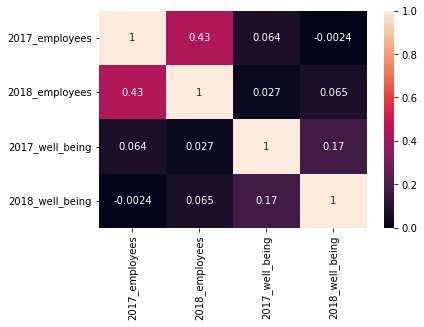

In [242]:
cols = ['2017_employees', '2018_employees', '2017_well_being', '2018_well_being']
sns.heatmap(df_set[cols].corr(), annot = True)

Но выводы делать пока рано, так как распределение сотрудников мало похоже на нормальное.

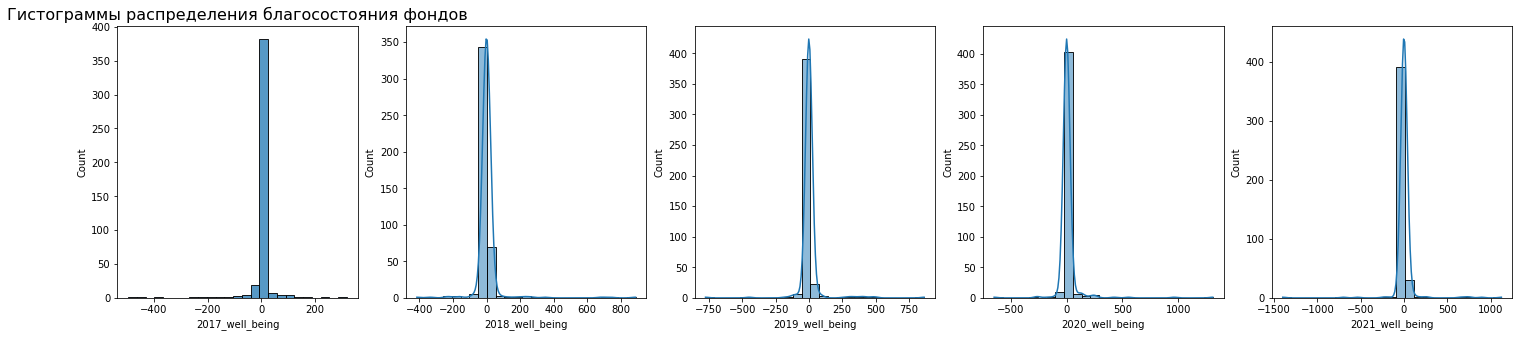

In [243]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
sns.histplot(
    data=df_set,
    x='2017_well_being',
    bins=25, #kde=True,
    ax=axes[0]
);
sns.histplot(
    data=df_set,
    x='2018_well_being',
    bins=25, kde=True,
    ax=axes[1]
);
sns.histplot(
    data=df_set,
    x='2019_well_being',
    bins=25, kde=True,
    ax=axes[2]
);
sns.histplot(
    data=df_set,
    x='2020_well_being',
    bins=25, kde=True,
    ax=axes[3]
);
sns.histplot(
    data=df_set,
    x='2021_well_being',
    bins=25, kde=True,
    ax=axes[4]
);

axes[0].set_title('Гистограммы распределения благосостояния фондов', fontsize=16);

## 2017 год

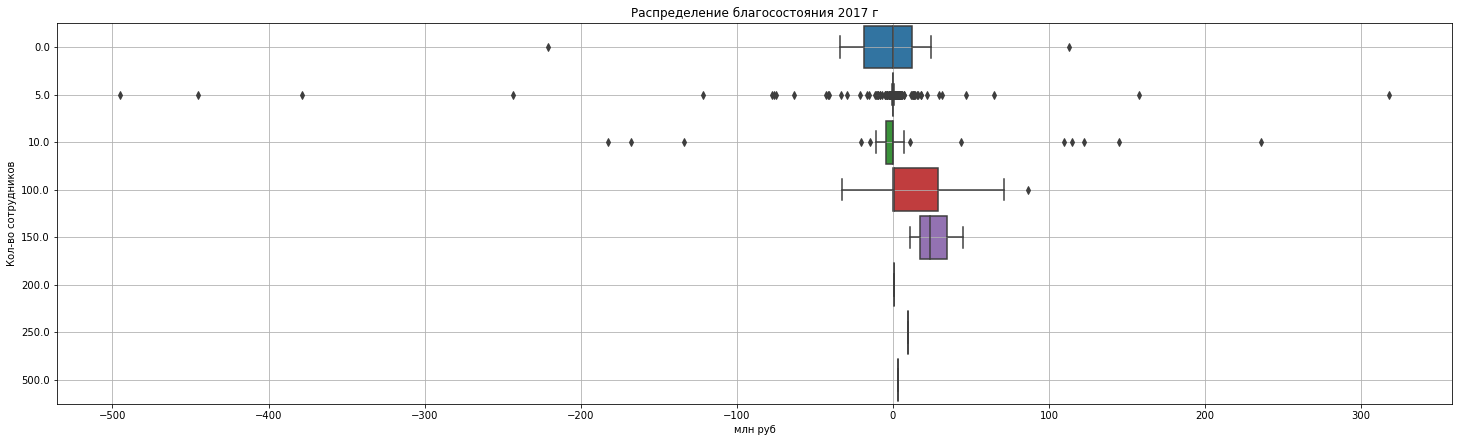

In [244]:
fig = plt.figure(figsize=(25, 7))
boxplot = sns.boxplot(
    data=df_set,
    x='2017_well_being',
    y='2017_employees',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение благосостояния 2017 г');
boxplot.set_xlabel('млн руб');
boxplot.set_ylabel('Кол-во сотрудников');
boxplot.grid()


In [245]:
top_of_Well_being_2017 = df_set[df_set['2017_well_being'] > 100]
display(top_of_the_top)

NameError: name 'top_of_the_top' is not defined

## 2018 год

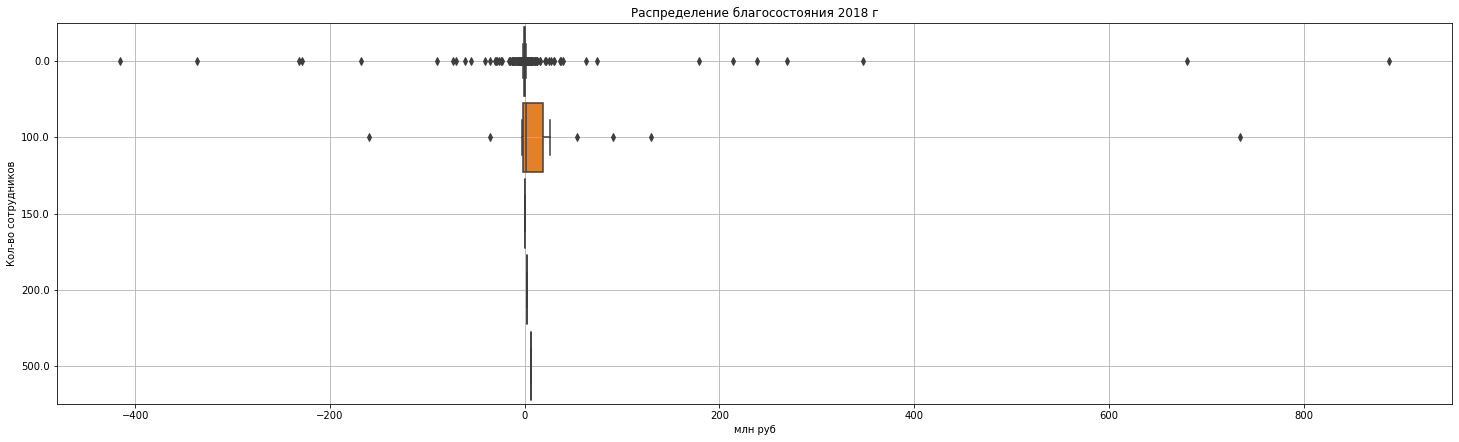

In [ ]:
fig = plt.figure(figsize=(25, 7))
boxplot = sns.boxplot(
    data=df_set,
    x='2018_well_being',
    y='2018_employees',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение благосостояния 2018 г');
boxplot.set_xlabel('млн руб');
boxplot.set_ylabel('Кол-во сотрудников');
boxplot.grid()

In [ ]:
top_of_Well_being_2018 = df_set[df_set['2018_well_being'] > 100]
display(top_of_the_top)

,name,legal_form,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being
6,"5541 ДОБРО, БФ",Благотворительные фонды,0.0,100.0,112.905,-160.072,-16.274,0.156,5.926
1645,"ЛИНИЯ ЖИЗНИ, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД СПАСЕНИЯ Т...",Благотворительные фонды,10.0,0.0,144.825,62.883,-106.841,-56.120,74.046
2608,РАЗВИТИЯ ВЕНЧУРНОГО ИНВЕСТИРОВАНИЯ ГОРОДА МОСК...,Общественные фонды,10.0,0.0,122.516,15.615,16.818,20.748,-24.176
2637,"РДФ, ООБФ",Благотворительные фонды,10.0,0.0,109.284,12.318,-11.060,36.756,14.897
2644,"РЕГИОНАЛЬНАЯ ПЛАТФОРМА, ФОНД",Общественные фонды,5.0,0.0,317.504,348.034,472.338,962.983,-700.545
3374,"ФОНД ПОДДЕРЖКИ ОЛИМПИЙЦЕВ РОССИИ, НБО",Благотворительные фонды,10.0,0.0,235.767,-415.215,864.543,-1.970,-241.497
3541,"ЧЕРНОМЫРДИНА, ФОНД",Общественные фонды,5.0,0.0,157.760,887.283,-775.439,7.344,8.822
3574,"ШКОЛЫ МИРА, ФОНД",Благотворительные фонды,10.0,0.0,114.894,21.784,-108.448,6.717,25.957


## 2019 год

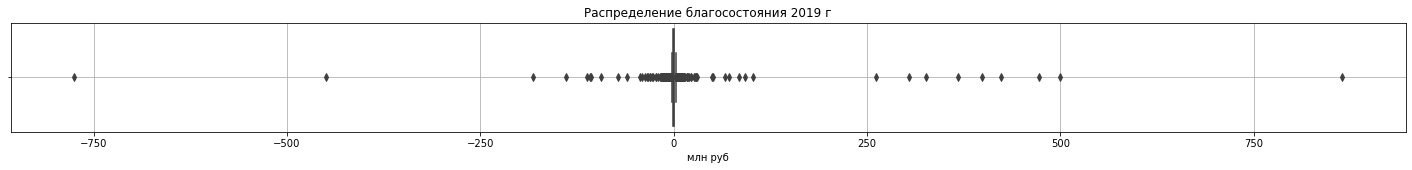

In [ ]:
fig = plt.figure(figsize=(25, 2))
boxplot = sns.boxplot(
    data=df_set,
    x='2019_well_being',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение благосостояния 2019 г');
boxplot.set_xlabel('млн руб');
boxplot.grid()

## 2020 год

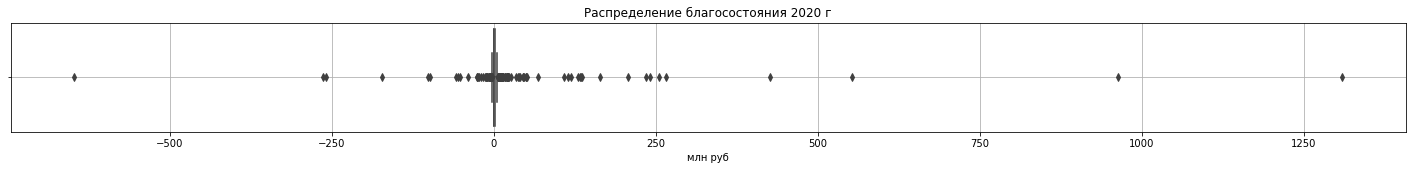

In [ ]:
fig = plt.figure(figsize=(25, 2))
boxplot = sns.boxplot(
    data=df_set,
    x='2020_well_being',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение благосостояния 2020 г');
boxplot.set_xlabel('млн руб');
boxplot.grid()

## 2021 год

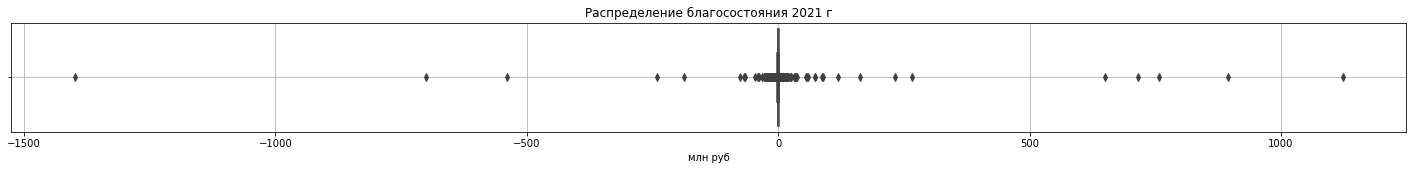

In [ ]:
fig = plt.figure(figsize=(25, 2))
boxplot = sns.boxplot(
    data=df_set,
    x='2021_well_being',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение благосостояния 2021 г');
boxplot.set_xlabel('млн руб');
boxplot.grid()

### Посмотрим на распределение признаков по двум осям

### 2017 год

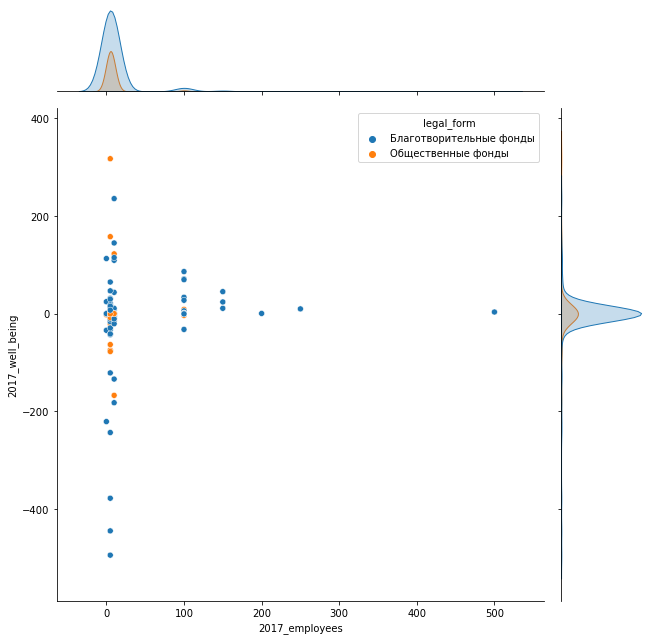

In [ ]:
jointplot = sns.jointplot(
    data=df_set, 
    x='2017_employees', 
    y='2017_well_being',
    hue='legal_form',
    height=9
    );

### 2018 год

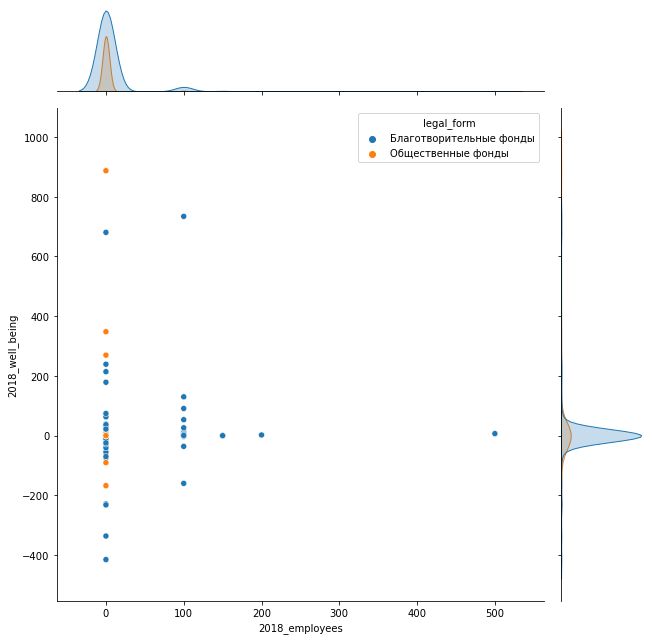

In [ ]:
jointplot = sns.jointplot(
    data=df_set, 
    x='2018_employees', 
    y='2018_well_being',
    hue='legal_form',
    height=9
    );

### Создадим новые признаки
### 1. Коэффициент отношения благополучия к числу сотрудников по годам
### 2. Коэффициент затрат на содержание аппарта управления к числу сотрудников
Рвсчеты будем проводить только для тех фондов, у которых дано не нулевое число сотрудников

In [ ]:
z_mask_2017 = (df_set['2017_employees'] > 0) 
z_mask_2018 = (df_set['2018_employees'] > 0)

df_set_2017 = df_set[z_mask_2017]
df_set_2018 = df_set[z_mask_2018]

df_set_2017['2017_k_well_being'] = df_set_2017['2017_well_being']/df_set_2017['2017_employees']
df_set_2017['2017_k_costs'] = df_set_2017['2017_management_costs']/df_set_2017['2017_employees']

df_set_2018['2018_k_well_being'] = df_set_2018['2018_well_being']/df_set_2018['2018_employees']
df_set_2018['2018_k_costs'] = df_set_2018['2018_management_costs']/df_set_2018['2018_employees']

In [247]:
df_set_2017.head()

,name,legal_form,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being,2017_management_costs,2018_management_costs,2019_management_costs,2020_management_costs,2021_management_costs,2017_k_well_being,2017_k_costs
2,"1ПОМОГАЕТ, БФ",Благотворительные фонды,5.0,0.0,0.075,1.076,-0.104,-0.207,1.415,213000.0,243000.0,877000.0,1549000.0,1438000.0,0.0150,42600.0
15,"А.УСМАНОВА, ФОНД",Благотворительные фонды,5.0,0.0,0.484,0.000,16.838,-3.191,-4.291,1497000.0,0.0,1859000.0,2067000.0,2450000.0,0.0968,299400.0
23,"АВИАЦИОННО-КОСМИЧЕСКИЙ ФОНД, МОФ",Общественные фонды,5.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
57,"АЛЕКСАНДР, БФ",Благотворительные фонды,5.0,0.0,-0.013,-0.088,-0.008,-0.028,2.053,496000.0,408000.0,18000.0,0.0,0.0,-0.0026,99200.0
64,"АЛИНЫ КАБАЕВОЙ, ФОНД",Благотворительные фонды,5.0,0.0,-7.958,39.101,-12.693,-8.116,0.000,5290000.0,6023000.0,6797000.0,3776000.0,0.0,-1.5916,1058000.0


In [251]:
df_set_2018.head()

,name,legal_form,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being,2017_management_costs,2018_management_costs,2019_management_costs,2020_management_costs,2021_management_costs,2018_k_well_being,2018_k_costs
6,"5541 ДОБРО, БФ",Благотворительные фонды,0.0,100.0,112.905,-160.072,-16.274,0.156,5.926,16211000.0,57590000.0,52261000.0,39290000.0,42953000.0,-1.60072,575900.0
33,"АДВОКАТСКАЯ ИНИЦИАТИВА, ФОНД",Общественные фонды,0.0,100.0,-2.353,1.182,84.102,-0.249,-0.110,6138000.0,5795000.0,-5241000.0,8735000.0,7130000.0,0.01182,57950.0
112,"АРИФМЕТИКА ДОБРА, БФ",Благотворительные фонды,100.0,100.0,33.470,-2.333,-12.285,-1.002,89.304,16039000.0,21112000.0,26295000.0,25276000.0,26615000.0,-0.02333,211120.0
423,БЛАГОТВОРИТЕЛЬНЫЙ ФОНД РАЗВИТИЯ ФИЛАНТРОПИИ,Благотворительные фонды,0.0,100.0,-34.148,11.338,0.000,234.467,119.224,31557000.0,35409000.0,0.0,20301000.0,22892000.0,0.11338,354090.0
613,"ВЕРА, БЛАГОТВОРИТЕЛЬНЫЙ ФОНД",Благотворительные фонды,100.0,100.0,71.151,0.707,49.160,21.834,-20.918,26397000.0,23678000.0,26781000.0,32549000.0,37544000.0,0.00707,236780.0


### 2017 год

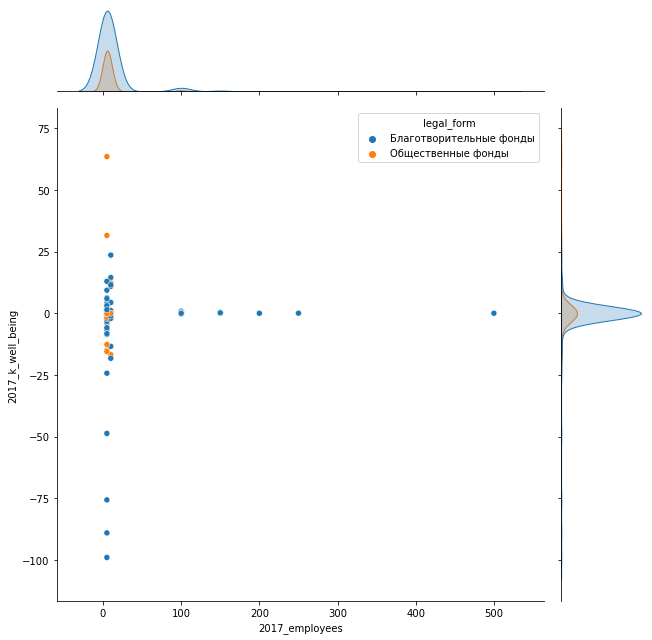

In [248]:
jointplot = sns.jointplot(
    data=df_set_2017, 
    x='2017_employees', 
    y='2017_k_well_being',
    hue='legal_form',
    height=9
    );

### 2018 год

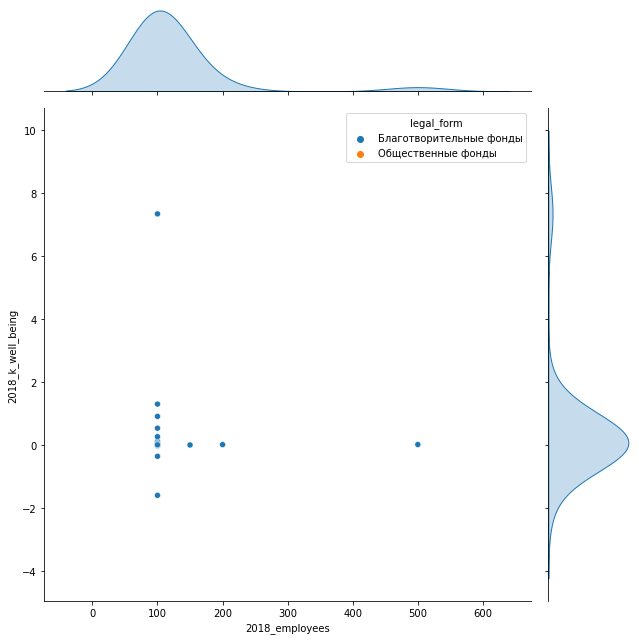

In [250]:
jointplot = sns.jointplot(
    data=df_set_2018, 
    x='2018_employees', 
    y='2018_k_well_being',
    hue='legal_form',
    height=9
    );

#### Зададим порог размера благосостояния, по превышению которого, фонд будет попадать к нам в наблюдение

In [177]:
MAX_WELL = 100 # Более 100 млн руб остатка на балансе

Настроим маски для фильтрации фондов

In [182]:
mask_2017 = (df_set['2017_well_being'] > MAX_WELL)
mask_2018 = (df_set['2018_well_being'] > MAX_WELL) 
mask_2019 = (df_set['2019_well_being'] > MAX_WELL)
mask_2020 = (df_set['2020_well_being'] > MAX_WELL)
mask_2021 = (df_set['2021_well_being'] > MAX_WELL)

In [183]:
top_balance = df_set[mask_2017 | mask_2018 | mask_2019 | mask_2020 | mask_2021]

print('В нашу выборку попадает:', top_balance.shape[0], 'фондов')

В нашу выборку попадает: 33 фондов


In [184]:
top_balance.head()

,name,legal_form,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being
6,"5541 ДОБРО, БФ",Благотворительные фонды,0.0,100.0,112.905,-160.072,-16.274,0.156,5.926
184,"БЛАГО, БФ",Благотворительные фонды,5.0,0.0,2.525,0.000,25.908,-23.429,649.634
423,БЛАГОТВОРИТЕЛЬНЫЙ ФОНД РАЗВИТИЯ ФИЛАНТРОПИИ,Благотворительные фонды,0.0,100.0,-34.148,11.338,0.000,234.467,119.224
535,БФ СОЦИАЛЬНОГО РАЗВИТИЯ РЕГИОНОВ,Благотворительные фонды,5.0,0.0,-0.073,-3.169,7.024,129.717,232.064
675,ВКЛАД В БУДУЩЕЕ,Благотворительные фонды,5.0,0.0,18.209,239.031,-16.441,19.497,17.781


### Основные статистики по нашим метрикам

In [185]:
top_balance.describe()

,2017_employees,2018_employees,2017_well_being,2018_well_being,2019_well_being,2020_well_being,2021_well_being
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,18.484848,21.212121,0.885818,83.716545,69.114636,127.541121,52.501242
std,36.389491,41.514875,149.887645,267.494130,291.705887,336.037109,450.863838
min,0.000000,0.000000,-445.174000,-415.215000,-775.439000,-648.250000,-1399.455000
25%,5.000000,0.000000,-32.367000,-3.169000,-28.312000,0.156000,-40.900000
50%,5.000000,0.000000,2.525000,12.318000,7.024000,108.159000,5.926000
75%,10.000000,0.000000,69.700000,129.852000,261.916000,206.129000,119.224000
max,150.000000,100.000000,317.504000,887.283000,864.543000,1309.543000,1123.365000


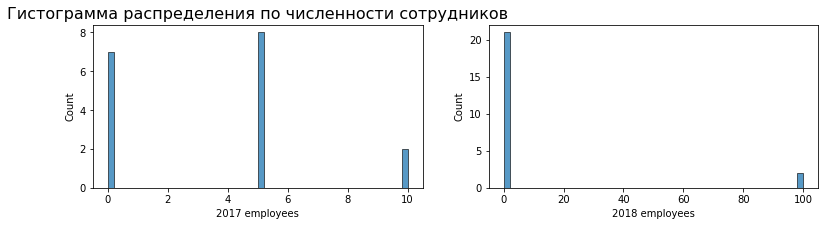

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 3))
sns.histplot(
    data=top_balance_set,
    x='2017 employees',
    bins=50, #kde=True,
    ax=axes[0]
);

sns.histplot(
    data=top_balance_set,
    x='2018 employees',
    bins=50, #kde=True,
    ax=axes[1]
);
axes[0].set_title('Гистограмма распределения по численности сотрудников', fontsize=16);

### Посмотрим на распределение прибыли по годам, для наших топов

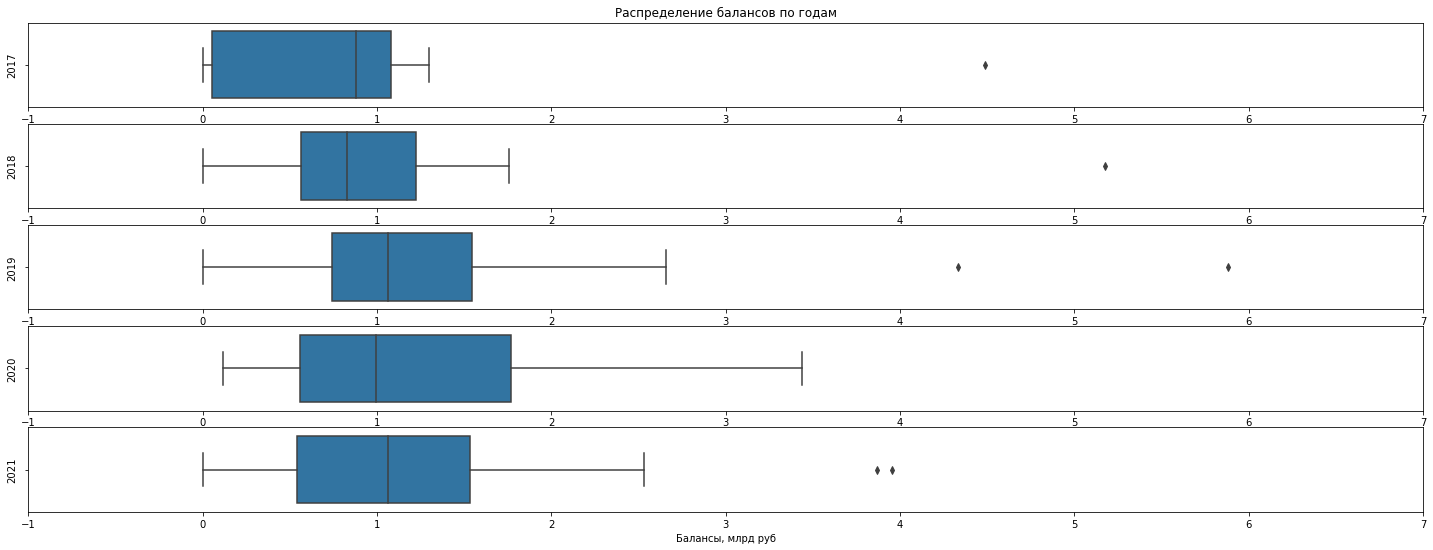

In [162]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(25, 9))

boxplot1 = sns.boxplot(
    data=top_balance_set,
    x="2017 balance", 
    orient='h', ax=axes[0]
)
boxplot1.set_ylabel('2017');
boxplot1.set_xticks([x for x in range(-1, 8)]);
boxplot1.set_title('Распределение балансов по годам');
boxplot2 = sns.boxplot(
    data=top_balance_set,
    x="2018 balance",
    orient='h', ax=axes[1]
)
boxplot2.set_ylabel('2018');
boxplot2.set_xticks([x for x in range(-1, 8)]);
boxplot3 = sns.boxplot(
    data=top_balance_set,
    x="2019 balance",
    orient='h', ax=axes[2]
)
boxplot3.set_ylabel('2019');
boxplot3.set_xticks([x for x in range(-1, 8)]);
boxplot4 = sns.boxplot(
    data=top_balance_set,
    x="2020 balance", 
    orient='h', ax=axes[3]
)
boxplot4.set_ylabel('2020');
boxplot4.set_xticks([x for x in range(-1, 8)]);
boxplot5 = sns.boxplot(
    data=top_balance_set,
    x="2021 balance",
    orient='h', ax=axes[4]
)
boxplot5.set_ylabel('2021');
boxplot5.set_xticks([x for x in range(-1, 8)]);


boxplot5.set_xlabel('Балансы, млрд руб');

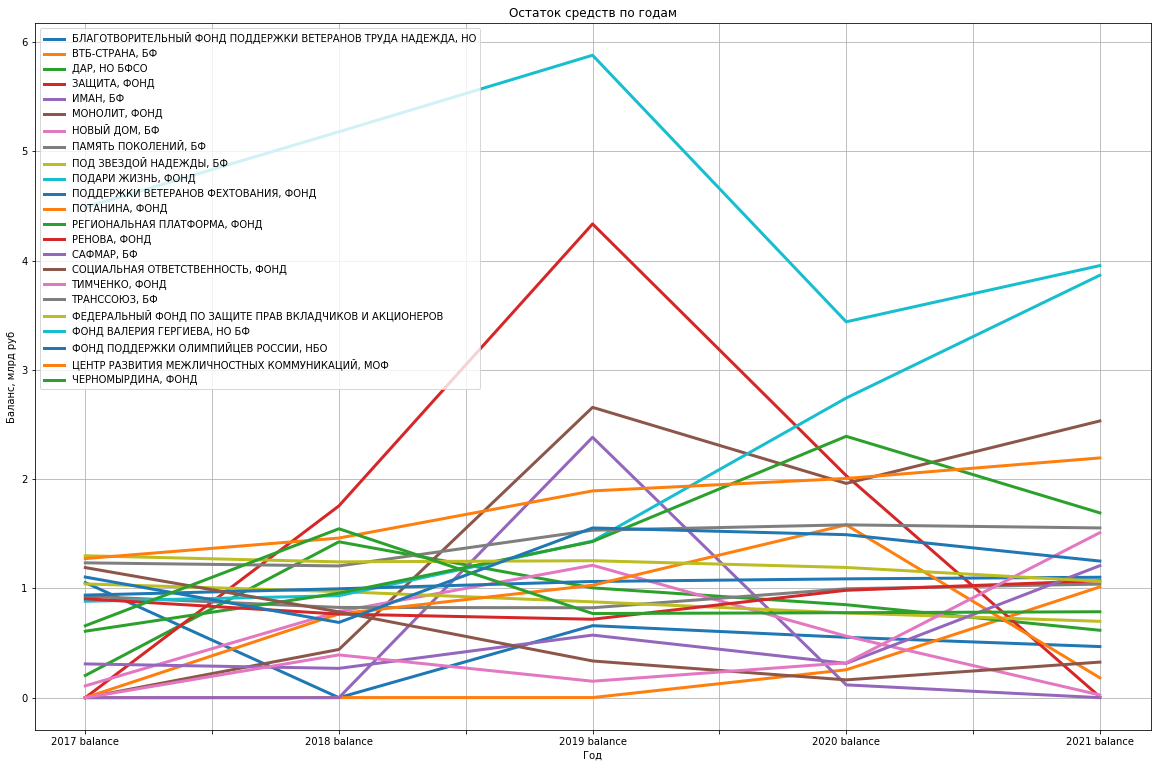

In [163]:
for idx, row in top_balance_set.iterrows():
    row[3:].plot(
    kind='line', figsize=(20, 13),
    title='Остаток средств по годам',
    grid = True, lw=3
    );
    plt.xlabel('Год')
    plt.ylabel('Баланс, млрд руб')
    plt.legend(top_balance_set['Наименование'])

### Отдельно рассмотрим самый топ по прибыли

In [164]:
top_of_the_top_set = top_of_the_top[cols]
display(top_of_the_top_set)

,Наименование,2017 employees,2018 employees,2017 balance,2018 balance,2019 balance,2020 balance,2021 balance
1935,"НАБАТ-3, БЛАГОТВОРИТЕЛЬНЫЙ ОБЩЕСТВЕННЫЙ ФОНД",0.0,0.0,9.0,0.000000,9.000000,0.000000,0.0
3346,ФОНД ИМЕНИ АЛЕКСАНДРОВА,0.0,0.0,0.0,16.063862,8.826705,1.188367,0.0


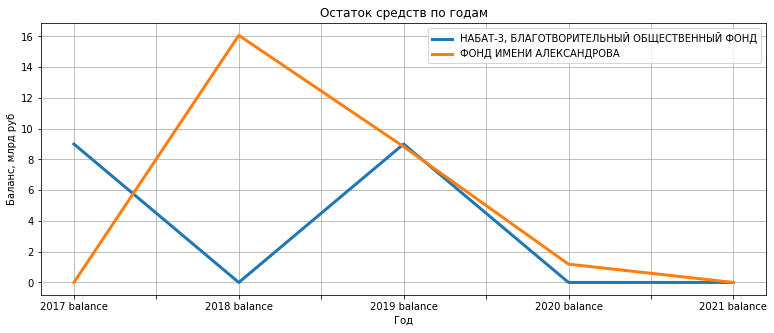

In [165]:
for idx, row in top_of_the_top_set.iterrows():
    row[3:].plot(
    kind='line', figsize=(13, 5),
    title='Остаток средств по годам',
    grid = True, lw=3
    );
    plt.xlabel('Год')
    plt.ylabel('Баланс, млрд руб')
    plt.legend(top_of_the_top_set['Наименование'])

### Оценим распределение балансов по районам Москвы

#### Сгруппируем сначала по расположению (Север, Центр и т.д.)

In [200]:
cols_balance = [
    'Наименование', 
    '2017 balance', '2018 balance', '2019 balance', 
    '2020 balance', '2021 balance', 
    'direction', 'location_name']
top_balance = df[mask_2017 | mask_2018 | mask_2019 | mask_2020 | mask_2021][cols_balance]

group_balance_loc = top_balance.groupby(by='direction').sum()

display(group_balance_loc)

,2017 balance,2018 balance,2019 balance,2020 balance,2021 balance
direction,,,,,
Восточный,1.298727,1.683830,3.909738,3.151936,3.596833
Западный,0.928283,0.825623,0.822824,0.996377,1.039373
Северный,1.934986,16.996859,10.918161,4.482608,4.332583
Центральный,20.623966,16.766555,33.516446,18.937421,17.544407
Юго-Западный,1.393533,2.211384,1.340680,1.013412,0.942314
Южный,1.040750,0.970777,0.876809,0.775088,0.698614


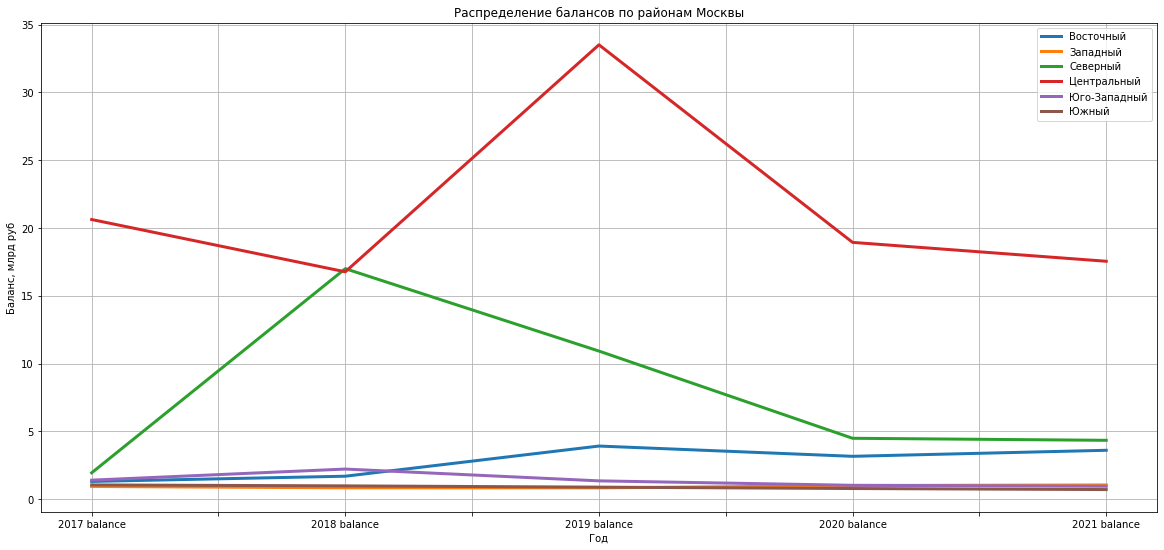

In [201]:
for idx, row in group_balance_loc.iterrows():
    row.plot(
    kind='line', figsize=(20, 9),
    title='Распределение балансов по районам Москвы',
    grid = True, lw=3
    );
    plt.xlabel('Год')
    plt.ylabel('Баланс, млрд руб')
    plt.legend(group_balance_loc.index)

#### А теперь сгруппируем по названию района

In [202]:
group_balance_reg = top_balance.groupby(by='location_name').sum()

display(group_balance_reg)

,2017 balance,2018 balance,2019 balance,2020 balance,2021 balance
location_name,,,,,
Арбат,2.211136,2.456883,2.955234,3.092912,3.295415
Басманный,9.000000,0.000000,9.000000,0.000000,0.000000
Донской,1.040750,0.970777,0.876809,0.775088,0.698614
Дорогомилово,0.928283,0.825623,0.822824,0.996377,1.039373
Замоскворечье,1.872259,2.578859,2.060388,2.073862,3.063742
Измайлово,1.298727,1.242721,1.253192,1.191423,1.064896
Красносельский,1.233673,1.205557,1.531963,1.581355,1.553079
Мещанский,4.486830,5.177858,5.878155,3.439137,3.953372
Обручевский,0.203101,1.426243,1.004811,0.850606,0.616768


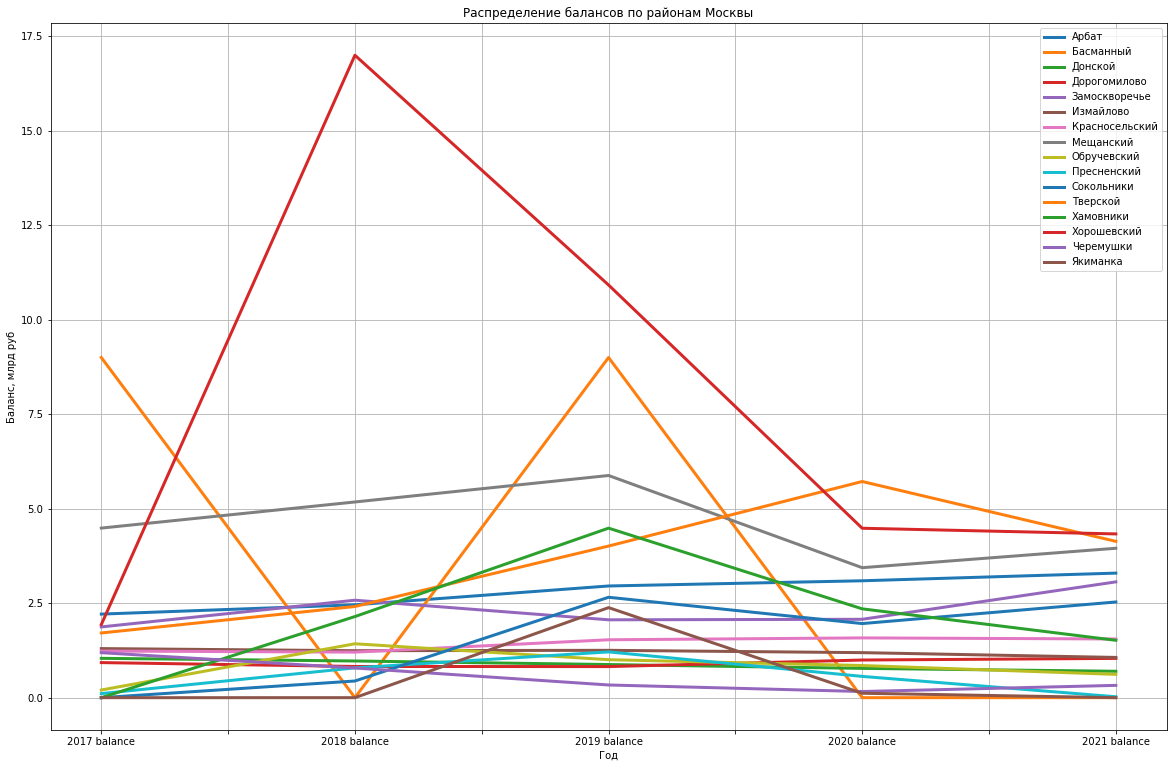

In [203]:
for idx, row in group_balance_reg.iterrows():
    row.plot(
    kind='line', figsize=(20, 13),
    title='Распределение балансов по районам Москвы',
    grid = True, lw=3
    );
    plt.xlabel('Год')
    plt.ylabel('Баланс, млрд руб')
    plt.legend(group_balance_reg.index)